In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [74]:
# Import a series of files from WOI. Here I just use their download functionality to get CSV files
def import_WOI_datasets(files):
    results = None
    for file in files:
        data = pd.read_csv(file)
        data['source'] = pd.Series([file] * len(data.index), index=data.index)
        if results is None:
            results = data
        else:
            results = pd.concat([results, data])
    return results

# Join in the league-wide number of goals and saves
def generate_aggregate_shots(stat_table):
    chunk_shots = stat_table.groupby(['season', 'source'], as_index=False)
    agg_stats = chunk_shots[['G.L', 'S.L', 'G.M', 'S.M', 'G.H', 'S.H']].sum()
    stats = pd.merge(stat_table, agg_stats, on=['season', 'source'], how='left', suffixes=('','_all'))
    stats['Sh.L_all'] = stats['G.L_all'] + stats['S.L_all']
    stats['Sh.M_all'] = stats['G.M_all'] + stats['S.M_all']
    stats['Sh.H_all'] = stats['G.H_all'] + stats['S.H_all']
    
    stats['adj'] = (stats['Sv%L'] * stats['Sh.L_all'] + stats['Sv%M'] * stats['Sh.M_all'] + 
                       stats['Sv%H'] * stats['Sh.H_all']) / (stats['Sh.L_all'] + stats['Sh.M_all'] + stats['Sh.H_all'])
    return stats

# Merge values across situation types into one data frame
def flatten_situations(stat_table, param):
    for source in stat_table.source.unique():
        stat_table = pd.merge(stat_table, stat_table.loc[stat_table['source'] == source, ['season', 'Name', param]], 
                    on=['season', 'Name'], how='left', suffixes=('','_' + source))
        
    return stat_table

# Include aggregate shot data and calculate adjusted save percentage
def flatten_shots(stat_table):
    chunk_shots = stat_table.groupby(['season', 'source'], as_index=False)
    agg_shots = chunk_shots[['Sh']].sum()
    num_goalies = pd.DataFrame({'count' : stat_table.groupby(['season', 'source'], as_index=False).size()}).reset_index()

    for source in stat_table.source.unique():
        stat_table = pd.merge(stat_table, agg_shots.loc[agg_shots['source'] == source, ['season', 'Sh', 'G']], 
                on=['season'], how='left', suffixes=('','_agg_' + source))
        stat_table = pd.merge(stat_table, num_goalies.loc[num_goalies['source'] == source, ['season', 'count']], 
                on=['season'], how='left', suffixes=('', '_' + source))

        # Rename
        if 'count_' + source not in stat_table.columns:
            stat_table.rename(columns={'count': 'count_' + source}, inplace=True)   
 
    return stat_table

# Perform the adjustment across multiple categories
def calculate_joint_adsv(stat_table):
    numer = [len(stat_table)*0]
    denom = [len(stat_table)*0]
    
    for source in stat_table.source.unique():
        #stat_table['adj_' + source].fillna(0, inplace=True)
        #stat_table['Sh_agg_' + source].fillna(0, inplace=True)
        #stat_table['adj_' + source].fillna(stat_table['G_agg_' + source]/stat_table['Sh_agg_' + source], inplace=True)
        numer = numer + stat_table['adj_' + source]*stat_table['Sh_agg_' + source]
        denom = denom + stat_table['Sh_agg_' + source]   

    stat_table['adj_agg'] = numer/denom

    return stat_table
    
# Please see http://jackman.stanford.edu/classes/BASS/ch2.pdf or 
# http://web.as.uky.edu/statistics/users/pbreheny/701/S13/notes/1-15.pdf
# Note: Equation often used with -1 and -2, as the mode of the posterior density
def calculate_priors(stat_table, weight):
    for source in stat_table.source.unique():
        for situ in ['L', 'M', 'H']:
            alpha = weight * (stat_table['G.' + situ + '_all'] + stat_table['S.' + situ + '_all'])/stat_table['count_' + source]
            beta = weight * stat_table['G.' + situ + '_all']/stat_table['count_' + source]
            stat_table['bayes_Sv%' + situ] = (alpha + stat_table['S.' + situ])/(alpha + beta + stat_table['G.' + situ] + 
                                                                          stat_table['S.' + situ])
            # stat_table['bayes_Sv%' + situ].fillna(0, inplace=True)
            
            stat_table['numer'] = (alpha + stat_table['S.' + situ])
            stat_table['denom'] = (alpha + beta + stat_table['G.' + situ] + stat_table['S.' + situ]);

        stat_table['adj_bayes'] = 100*(stat_table['bayes_Sv%L'] * stat_table['Sh.L_all'] + 
                                   stat_table['bayes_Sv%M'] * stat_table['Sh.M_all'] + 
                                   stat_table['bayes_Sv%H'] * stat_table['Sh.H_all']) / (stat_table['Sh.L_all'] + 
                                                                stat_table['Sh.M_all'] + stat_table['Sh.H_all'])
        
    table2 = flatten_situations(stat_table, 'adj_bayes')

    numer = [len(table2) * 0]
    denom = [len(table2) * 0]
    
    for source in table2.source.unique():
        #table2['adj_bayes_' + source].fillna(0, inplace=True)
        #table2['Sh_agg_' + source].fillna(0, inplace=True)
        
        numer = numer + table2['adj_bayes_' + source]*table2['Sh_agg_' + source]
        denom = denom + table2['Sh_agg_' + source]   
        
    table2['adj_bayes'] = numer/denom
    
    return table2

# Build up the aggregate statistics
def generate_statistics(raw, weight=1):
    stat_table = generate_aggregate_shots(raw)
    stat_table2 = flatten_situations(stat_table, 'adj')
    stat_table3 = calculate_joint_adsv(flatten_shots(stat_table2))
    return calculate_priors(stat_table3, weight)

In [ ]:
# Import our data
# For this analysis I've restricted it to goalies with 30+ minutes played.

results_all = import_WOI_datasets(['5v5.csv', '4v4.csv', 'pp.csv', 'short.csv', 'other_pulled.csv', 'leftovers.csv'])
results_most = import_WOI_datasets(['5v5.csv', '4v4.csv', 'pp.csv', 'short.csv'])
results_with_sh = import_WOI_datasets(['5v5.csv', 'short.csv'])

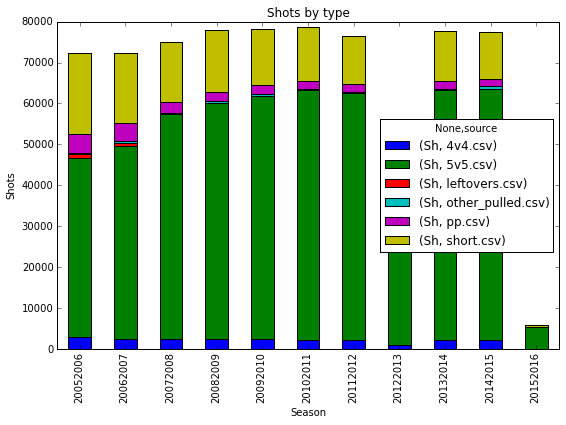

In [4]:
# Show aggregate situation type over time

chunk = results_all.groupby(['season', 'source'])
shot_plot = chunk.agg({'Sh': np.sum}).unstack().plot(kind='bar', stacked=True, title='Shots by type', figsize=(9, 7))
shot_plot.set_xlabel('Season')
shot_plot.set_ylabel('Shots')
plt.gcf().subplots_adjust(bottom=0.25)
plt.show()

In [52]:
# Check that my calculation of AdSv% is quite close to the War on Ice one. Mine may differ because I only pulled goalies
# with 30+ minutes played

stat_table_sh = generate_statistics(results_with_sh)

print(stat_table_sh[['AdSv%', 'adj']].corr(method='pearson'))
print(stat_table_sh[['AdSv%', 'adj']].corr(method='spearman'))

          AdSv%       adj
AdSv%  1.000000  0.997843
adj    0.997843  1.000000
          AdSv%       adj
AdSv%  1.000000  0.998015
adj    0.998015  1.000000


In [33]:
# Look at save percentage by situation-location

chunk = results_all.groupby(['source'], as_index=False)
tmp = chunk[['G.L', 'S.L', 'G.M', 'S.M', 'G.H', 'S.H']].sum()
tmp['Sv%L'] = tmp['S.L']/(tmp['S.L'] + tmp['G.L'])
tmp['Sv%M'] = tmp['S.M']/(tmp['S.M'] + tmp['G.M'])
tmp['Sv%H'] = tmp['S.H']/(tmp['S.H'] + tmp['G.H'])
tmp[['source', 'Sv%L', 'Sv%M', 'Sv%H']]

,source,Sv%L,Sv%M,Sv%H
0,4v4.csv,0.973921,0.928014,0.823616
1,5v5.csv,0.973950,0.928364,0.824784
2,leftovers.csv,0.998489,0.987805,0.952206
3,other_pulled.csv,0.954608,0.913772,0.787627
4,pp.csv,0.985296,0.947635,0.824028
5,short.csv,0.937052,0.876852,0.772617


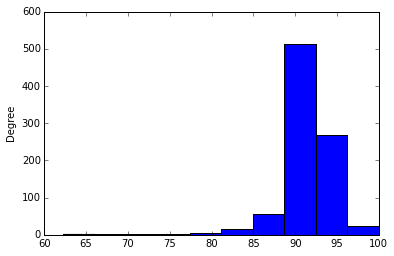

In [73]:
# Show the distribution of adjusted 5v5 save percentages

# stat_table_sh.head(10)
# stat_table_sh["source"].value_counts()
stat_table_sh.loc[stat_table_sh['source'] == '5v5.csv', 'adj_5v5.csv'].plot(kind='hist')
plt.show()

In [50]:
# Who correlation of the shorthanded version with the 5v5 version
# Note this isn't controlling for number of rows per goalie

tmp = stat_table_sh[stat_table_sh['TOI'] > 1000]

print(tmp[['adj', 'adj_agg']].corr(method='pearson'))
print(tmp[['adj', 'adj_agg']].corr(method='spearman'))

              adj   adj_agg
adj      1.000000  0.897953
adj_agg  0.897953  1.000000
              adj   adj_agg
adj      1.000000  0.900014
adj_agg  0.900014  1.000000


In [51]:
# Show correlations with Bayesian-adjusted metric

stat_table_bayes = generate_statistics(results_most)

tmp = stat_table_bayes[stat_table_bayes['TOI'] > 1000]

print(tmp[['adj', 'adj_agg']].corr(method='pearson'))
print(tmp[['adj', 'adj_agg']].corr(method='spearman'))

print(tmp[['adj_bayes', 'adj_agg']].corr(method='pearson'))
print(tmp[['adj_bayes', 'adj_agg']].corr(method='spearman'))

              adj   adj_agg
adj      1.000000  0.882395
adj_agg  0.882395  1.000000
              adj   adj_agg
adj      1.000000  0.879524
adj_agg  0.879524  1.000000
           adj_bayes   adj_agg
adj_bayes   1.000000  0.918558
adj_agg     0.918558  1.000000
           adj_bayes  adj_agg
adj_bayes    1.00000  0.92813
adj_agg      0.92813  1.00000


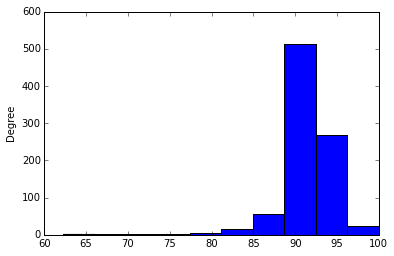

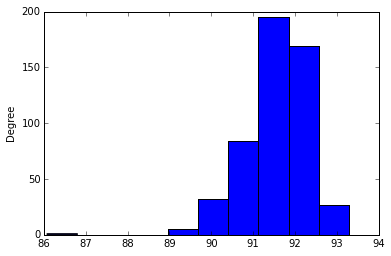

In [53]:
tmp = stat_table_bayes[stat_table_bayes['source'] == '5v5.csv']
tmp['adj'].plot(kind='hist')
plt.show()

tmp['adj_bayes'].plot(kind='hist')
plt.show()

In [85]:
# We can observe different tightening of the distribution by playing with weights.
# 0.5 here might give a reasonable distribution - however, I'd much prefer to
# actually give a better grounding based on a smarter prior
stat_table_bayes_weak = generate_statistics(results_most, 0.5)

#input = stat_table_bayes_weak
input = stat_table_bayes

tmp = input[(input['source'] == '5v5.csv') & (input['TOI'] > 1000) & (input['season'] == 20142015)]
tmp['adj_rank'] = tmp.adj.rank(ascending=False)
tmp['adj_agg_rank'] = tmp.adj_agg.rank(ascending=False)
tmp['adj_bayes_rank'] = tmp.adj_bayes.rank(ascending=False)
tmp[['season', 'Name', 'TOI', 'adj', 'adj_rank', 'adj_agg', 'adj_agg_rank', 'adj_bayes', 'adj_bayes_rank']].sort(columns="adj_bayes_rank")

C:\Users\Richard\Anaconda\lib\site-packages\IPython\kernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Richard\Anaconda\lib\site-packages\IPython\kernel\__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Richard\Anaconda\lib\site-packages\IPython\kernel\__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/

,season,Name,TOI,adj,adj_rank,adj_agg,adj_agg_rank,adj_bayes,adj_bayes_rank
84,20142015,Andrew.Hammond,1205.6,93.476184,5,93.175208,1,92.909631,1
60,20142015,Carey.Price,3777.9,94.032880,2,92.939637,2,92.859822,2
114,20142015,Cory.Schneider,3163.4,93.495587,4,92.824391,3,92.753077,3
56,20142015,Steve.Mason,2296.4,94.248804,1,92.697436,4,92.660638,4
236,20142015,Marc-Andre.Fleury,3186.1,93.087183,9,92.482678,5,92.509432,5
69,20142015,Craig.Anderson,1796.7,93.536987,3,92.442568,8,92.497345,6
154,20142015,Braden.Holtby,4048.0,92.955417,10,92.480595,6,92.491401,7
428,20142015,Semyon.Varlamov,2648.5,92.037822,32,92.477769,7,92.471275,8
124,20142015,Devan.Dubnyk,3190.4,93.131885,6,92.415683,9,92.459356,9
235,20142015,Ondrej.Pavelec,2335.3,92.868248,12,92.365668,10,92.419173,10


In [57]:
# Rank comparison between 5v5 and shorthanded

tmp = stat_table_sh[(stat_table_sh['source'] == '5v5.csv') & 
                       (stat_table_sh['TOI'] > 1000) & 
                       (stat_table_sh['season'] == 20142015)]
tmp['adj_rank'] = tmp.adj.rank(ascending=False)
tmp['adj_agg_rank'] = tmp.adj_agg.rank(ascending=False)
tmp['adj_bayes_rank'] = tmp.adj_bayes.rank(ascending=False)
tmp[['season', 'Name', 'TOI', 'adj', 'adj_agg', 'adj_rank', 'adj_agg_rank']].sort(columns="adj_agg_rank")

C:\Users\Richard\Anaconda\lib\site-packages\IPython\kernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Richard\Anaconda\lib\site-packages\IPython\kernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Richard\Anaconda\lib\site-packages\IPython\kernel\__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/

,season,Name,TOI,adj,adj_agg,adj_rank,adj_agg_rank
84,20142015,Andrew.Hammond,1205.6,93.476184,93.365165,5,1
114,20142015,Cory.Schneider,3163.4,93.495587,92.949912,4,2
60,20142015,Carey.Price,3777.9,94.032880,92.898899,2,3
236,20142015,Marc-Andre.Fleury,3186.1,93.087183,92.786080,9,4
56,20142015,Steve.Mason,2296.4,94.248804,92.733927,1,5
69,20142015,Craig.Anderson,1796.7,93.536987,92.600757,3,6
124,20142015,Devan.Dubnyk,3190.4,93.131885,92.552825,6,7
176,20142015,Corey.Crawford,3712.0,93.087839,92.411664,8,8
428,20142015,Semyon.Varlamov,2648.5,92.037822,92.411156,32,9
154,20142015,Braden.Holtby,4048.0,92.955417,92.367460,10,10


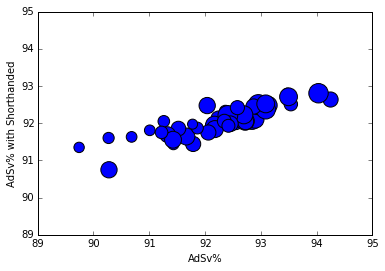

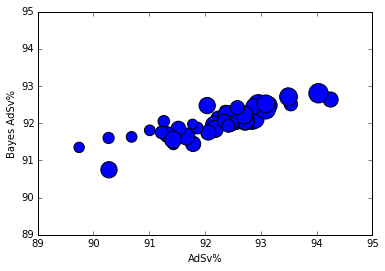

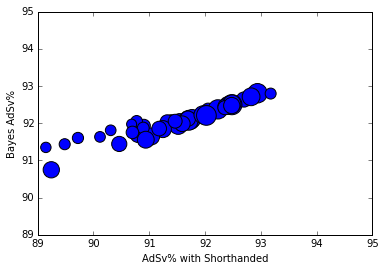

In [71]:
# Plots comparing movements

tmp.plot(kind='scatter', x='adj', y='adj_bayes', s=tmp['TOI']/10)
plt.xlim(89, 95)
plt.ylim(89, 95)
plt.xlabel('AdSv%')
plt.ylabel('AdSv% with Shorthanded')
plt.show()

tmp.plot(kind='scatter', x='adj', y='adj_bayes', s=tmp['TOI']/10)
plt.xlim(89, 95)
plt.ylim(89, 95)
plt.xlabel('AdSv%')
plt.ylabel('Bayes AdSv%')
plt.show()

tmp.plot(kind='scatter', x='adj_agg', y='adj_bayes', s=tmp['TOI']/10)
plt.xlim(89, 95)
plt.ylim(89, 95)
plt.xlabel('AdSv% with Shorthanded')
plt.ylabel('Bayes AdSv%')
plt.show()

In [58]:
# Compare NY and Ottawa goalies

tmp2 = tmp[tmp['Name'].isin(['Henrik.Lundqvist', 'Cam.Talbot', 'Andrew.Hammond', 'Craig.Anderson', 'Robin.Lehner'])]
tmp2[['season', 'Name', 'TOI', 'adj', 'adj_agg', 'adj_rank', 'adj_agg_rank', 'adj_5v5.csv', 'adj_short.csv']]

,season,Name,TOI,adj,adj_agg,adj_rank,adj_agg_rank,adj_5v5.csv,adj_short.csv
69,20142015,Craig.Anderson,1796.7,93.536987,92.600757,3,6,93.536987,87.523536
84,20142015,Andrew.Hammond,1205.6,93.476184,93.365165,5,1,93.476184,92.763103
139,20142015,Henrik.Lundqvist,3181.4,92.896316,91.551873,11,22,92.896316,84.260888
174,20142015,Cam.Talbot,1689.5,93.104981,92.060866,7,12,93.104981,86.398576
600,20142015,Robin.Lehner,1144.1,90.683317,89.845301,45,44,90.683317,85.300699


In [62]:
# Break down NY and Ottawa goalies by shot type

tmp3 = stat_table3[(stat_table3['Name'].isin(['Henrik.Lundqvist', 'Cam.Talbot', 'Andrew.Hammond', 'Craig.Anderson', 'Robin.Lehner'])) & 
                   (stat_table3['season'] == 20142015)]

tmp3[['Name', 'source', 'Sv%L', 'Sv%M', 'Sv%H']].sort(columns=['Name', 'source'])

,Name,source,Sv%L,Sv%M,Sv%H
84,Andrew.Hammond,5v5.csv,97.65,92.07,87.84
909,Andrew.Hammond,short.csv,96.30,88.46,91.18
174,Cam.Talbot,5v5.csv,96.68,94.03,86.17
1186,Cam.Talbot,short.csv,92.31,95.45,69.57
69,Craig.Anderson,5v5.csv,97.38,95.16,85.46
1025,Craig.Anderson,short.csv,94.59,90.38,74.36
139,Henrik.Lundqvist,5v5.csv,97.92,93.49,83.85
1410,Henrik.Lundqvist,short.csv,92.37,81.36,74.55
600,Robin.Lehner,5v5.csv,95.61,90.57,82.50
1394,Robin.Lehner,short.csv,87.50,92.31,75.86
